In [1]:
!pip install pgmpy
!pip install graphviz    #A
!apt install libgraphviz-dev    #A
!pip install pygraphviz    #A

import graphviz    #A
def plot_graph(G):    #A
    write_dot(G, 'graph.dot')    #A
    with open('graph.dot') as f:    #A
        dot_graph = f.read()    #A
    return graphviz.Source(dot_graph)    #A


import requests
url1 = "https://raw.githubusercontent.com/altdeep/causalML/master/book/pgmpy_do.py"     #B
response1 = requests.get(url1)     #B
exec(response1.text)     #B
url2 = "https://raw.githubusercontent.com/altdeep/causalML/master/book/chapter%209/hyp_function.py"     #C
response2 = requests.get(url2)     #C
exec(response2.text)     #C

#A Install raphviz for visualization and create a graphviz helper function. Graphviz installation may vary across environments.
#B Import a function for an ideal intervention.
#C Import a helper function for cloning assignment functions across worlds.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


We start by revisiting the SCM for the Monte Hall problem. Summarizing again, there is a game show where the player starts with a choice of three doors. Behind one door is a car. The player picks a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which does not have the car. The host gives the player the opportunity to switch doors.  In this case since the player picked No. 1 and the host revealed the car is not behind door No. 3, the player can switch to door No. 2. The question is whether a strategy of staying with the original choice or switching doors is better. The answer is, counterintuitively to many, that a switching strategy is better -- two times out of three, the switching strategy leads to a win.

We'll modify this game to have random inputs to the system that will behave as endogenous variables with prior distributions.  Specifically, we'll introduce two rolls of three-sided dice and a coin flip.

We'll call the first die roll "Car Door Die Roll", it selects a door for placement of the car.  The player rolls the second die, a variable we'll call "1st Choice Die Roll", to select the player's first door selection.  Both dice rolls assign a 1/3 probability to each outcome.

Next we have a coin flip, which will drive two outcomes.  Firstly, the host will use the outcome of the coin flip to select which door to open.  If the player selects the door with the car, when the host goes to reveal a carless door to the player, the host has two carless doors to choose from.  In this case, the host selects the right-most available door if he flips a heads, the left-most if he flips a tails.
Similarly, we'll assume the player leaves their decision of whether to switch doors or to stay with the original choice up to the coin flip as well.  If the coin flips heads, they switch, otherwise they stay.

In [2]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork


p_door_with_car = TabularCPD(    #A
    variable='Car Door Die Roll',    #A
    variable_card=3,    #A
    values=[[1/3], [1/3], [1/3]],    #A
    state_names={'Car Door Die Roll': ['1st', '2nd', '3rd']}    #A
)    #A

p_player_first_choice = TabularCPD(    #B
    variable='1st Choice Die Roll',    #B
    variable_card=3,    #B
    values=[[1/3], [1/3], [1/3]],    #B
    state_names={'1st Choice Die Roll': ['1st', '2nd', '3rd']}    #B
)    #B

p_coin_flip = TabularCPD(       #C
    variable='Coin Flip',    #C
    variable_card=2,    #C
    values=[[.5], [.5]],    #C
    state_names={'Coin Flip': ['tails', 'heads']}    #C
)    #C

#A Prior distribution on exogenous variable for the three-sided die roll that selects which door gets the car.
#B Prior distribution on the exogenous variable for the three-sided die roll that selects the player's first choice of door.
#C Prior distribution on the exogenous variable for the coin flip.  The host flips a coin. The coin flip impacts which door the host chooses to reveal as carless, and whether the player chooses a stay or switch strategy.

In [3]:
f_strategy = TabularCPD(    #A
    variable='Strategy',    #A
    variable_card=2,    #A
    values=[[1, 0], [0, 1]],    #A
    evidence=['Coin Flip'],    #A
    evidence_card=[2],    #A
    state_names={    #A
        'Strategy': ['stay', 'switch'],    #A
        'Coin Flip': ['tails', 'heads']}    #A
)    #A

f_host_door_selection = TabularCPD(    #B
    variable='Host Door Selection',    #B
    variable_card=3,    #B
    values=[    #B
        [0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0],    #B
        [1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1],    #B
        [0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0]    #B
    ],    #B
    evidence=['Coin Flip', 'Car Door Die Roll', '1st Choice Die Roll'],    #B
    evidence_card=[2, 3, 3],    #B
    state_names={    #B
        'Host Door Selection':['1st', '2nd', '3rd'],    #B
        'Coin Flip': ['tails', 'heads'],    #B
        'Car Door Die Roll': ['1st', '2nd', '3rd'],    #B
        '1st Choice Die Roll': ['1st', '2nd', '3rd']    #B
    }    #B
)    #B

f_second_choice = TabularCPD(    #C
    variable='2nd Choice',    #C
    variable_card=3,    #C
    values=[    #C
        [1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0],    #C
        [0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1],    #C
        [0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0]    #C
    ],    #C
    evidence=['Strategy', 'Host Door Selection', '1st Choice Die Roll'],    #C
    evidence_card=[2, 3, 3],    #C
    state_names={    #C
        '2nd Choice': ['1st', '2nd', '3rd'],    #C
        'Strategy': ['stay', 'switch'],    #C
        'Host Door Selection': ['1st', '2nd', '3rd'],    #C
        '1st Choice Die Roll': ['1st', '2nd', '3rd']    #C
    }    #C
)    #C

f_win_or_lose = TabularCPD(    #D
    variable='Win or Lose',    #D
    variable_card=2,    #D
    values=[    #D
        [1,0,0,0,1,0,0,0,1],    #D
        [0,1,1,1,0,1,1,1,0],    #D
    ],    #D
    evidence=['2nd Choice', 'Car Door Die Roll'],    #D
    evidence_card=[3, 3],    #D
    state_names={    #D
        'Win or Lose': ['win', 'lose'],    #D
        '2nd Choice': ['1st', '2nd', '3rd'],    #D
        'Car Door Die Roll': ['1st', '2nd', '3rd']    #D
    }    #D
)    #D
#A If the outcome of the coin flip was a heads, the player switches doors from their initial selection. Otherwise, they stay.
#B Host selects the door to reveal as carless based on the player's choice of door and the door with the car.  If those are the same door, the host has two doors to chose from.  If this case, if the coin fipped tails, the host chooses the left-most door, otherwise the right-most door.
#C The player chooses which door to select in the second round based on the choice in the first round (outcome of 1st Choice Die Roll), the door opened by the host, and whether the player's coin flip told them to stay or switch doors from their initial selection.
#D The player wins or loses based on their choice of door in the second round and the door with the car.


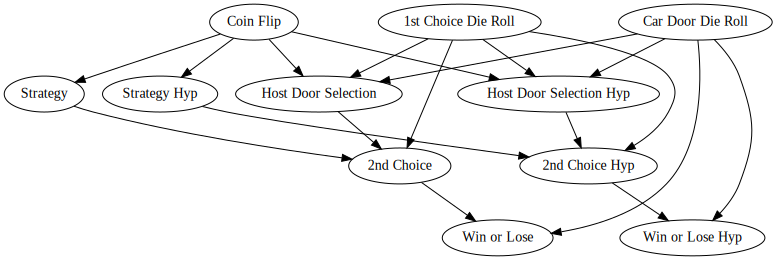

In [4]:
exogenous_vars = ["Car Door Die Roll", "Coin Flip", "1st Choice Die Roll"]    #A
endogenous_vars = ["Host Door Selection", "Strategy", "2nd Choice", "Win or Lose"]    #A

actual_world_edges = [    #B
    ('Coin Flip', 'Host Door Selection'),    #B
    ('Coin Flip', 'Strategy'),    #B
    ('Car Door Die Roll', 'Host Door Selection'),    #B
    ('1st Choice Die Roll', 'Host Door Selection'),    #B
    ('1st Choice Die Roll', '2nd Choice'),    #B
    ('Host Door Selection', '2nd Choice'),    #B
    ('Strategy', '2nd Choice'),    #B
    ('2nd Choice', 'Win or Lose'),    #B
    ('Car Door Die Roll', 'Win or Lose')    #B
]    #B

possible_world_edges = [    #C
    (a + " Hyp" if a in endogenous_vars else a,    #C
     b + " Hyp" if b in endogenous_vars else b)    #C
    for a, b in actual_world_edges    #C
]    #C

twin_world_graph = BayesianNetwork(    #D
    actual_world_edges +    #D
    possible_world_edges    #D
)    #D

twin_world_graph.add_cpds(    #E
    p_door_with_car,    #F
    p_player_first_choice,    #F
    p_coin_flip,    #F
    f_strategy,    #G
    f_host_door_selection,    #G
    f_second_choice,    #G
    f_win_or_lose,    #G
    clone(f_strategy),    #H
    clone(f_host_door_selection),    #H
    clone(f_second_choice),    #H
    clone(f_win_or_lose),    #H
)

plot_graph(twin_world_graph)

#A Specify lists of the exogenous and endogenous variables in the causal DAG.
#B Specify the edges of the SCM
#C Clone the edges for the hypothetical world
#D Create parallel world graph
#E Plot the parallel world graph
#F Add probability distributions on exogenous variables.
#G Add assignment functions from the SCM
#H Clone assignment functions

This creates are SCM, which we can use to generate samples.

As a sanity check, we confirm the result that the probability of winning is 2/3 if the player uses the switch strategy.


In [5]:
infer = VariableElimination(twin_world_graph)

strategy_outcome = infer.query(
    ['Win or Lose'],
    evidence={"Strategy": "switch"}
)
print(strategy_outcome)


+-------------------+--------------------+
| Win or Lose       |   phi(Win or Lose) |
+===================+====================+
| Win or Lose(win)  |             0.6667 |
+-------------------+--------------------+
| Win or Lose(lose) |             0.3333 |
+-------------------+--------------------+


Now, we explore how to run the counterfactual inference algorithm using this SCM.  Firstly, we need to apply an ideal intervention to implement the hypothetical condition of using the "switch" strategy.  The "do"-method of the BayesianNetwork object applies graph surgery.  To implement a full ideal intervention, we need to augment the method so that it additionally modifies the distribution to put all the probability on the intervention value.

We'll explore two counterfactual questions:



1.   For a player who stayed with their first door and lost, what is the probability that they would have won if they switched doors?
2.   For a player who lost, what is the probability they would have won if they switched doors?

In the *abduction step* of the counterfactual inference algorithm, we infer the exogenous variables given the actual conditions.  Let's confirm that we can infer

However, with the variable elimination inference algorithm, we need not do infer the exogenous variables directly.  Rather, we can implement a parallel world graph directly.  Then, when we condition on actual variables, the variable elimination algorithm will "eliminate" (meaning "sum over") all the exogenous variables (and any other latent variables) as it calculates the probabilities of outcomes for the hypothetical outcomes of interest.

Let's start by creating assignment functions for variables in the hypothetical world.  These will be the same as the original assignment functions, except we'll modify the names with "Hyp" to index the hypothetical world.

Finally, we use inference to answer the counterfactual questions.  Again, we use variable elimination as our choice of inference algorithm.



In [6]:
infer = VariableElimination(twin_world_graph)    #A

cf_dist1 = infer.query(    #B
    ['Win or Lose Hyp'],    #B
    evidence={'Strategy': 'stay', 'Win or Lose': 'lose'}    #B
)    #B
print(cf_dist1)

cf_dist2 = infer.query(    #C
    ['Win or Lose Hyp'],    #C
    evidence={'Win or Lose': 'lose'}    #C
)    #C
print(cf_dist2)

#A We apply variable elimination as our inference algorithm on the parallel world graph.
#B The inference query that answers "For a player who used the "stay" strategy and lost, would they have won if they used the "switch" strategy.  Conditional on Strategy == stay and 'Win or Lose' == lose, we infer the probability distribution of 'Win or Lose Hyp' on the parallel world graph.
#C The inference query that answers "For a player who lost, would they have won if they used the "switch" strategy.  Conditional on 'Win or Lose' == lose, we infer the probability distribution of 'Win or Lose Hyp' on the parallel world graph.

+-----------------------+------------------------+
| Win or Lose Hyp       |   phi(Win or Lose Hyp) |
+=======================+========================+
| Win or Lose Hyp(win)  |                 0.0000 |
+-----------------------+------------------------+
| Win or Lose Hyp(lose) |                 1.0000 |
+-----------------------+------------------------+
+-----------------------+------------------------+
| Win or Lose Hyp       |   phi(Win or Lose Hyp) |
+=======================+========================+
| Win or Lose Hyp(win)  |                 0.0000 |
+-----------------------+------------------------+
| Win or Lose Hyp(lose) |                 1.0000 |
+-----------------------+------------------------+


We can validate these answers with a bit of simple reasoning.

The answer to the first question is perhaps obvious.  If the player lost on a "stay" strategy, then the their first choice did not have the car.  Then one of the other two doors must have had the car.  Of those two, the host would have had to open the one without the car.  The remain door has the car, and that is the only door the player can switch to on a switch strategy.  So, conditional on having lost with a stay strategy, the chances they would have won with a switch strategy are 100%.

The answer to the second question extends from the first.  If we know a player lost but didn't know which strategy they used, then there is a 2/3 chance it was a stay strategy.  As we saw from the first question, in this case flipping to a "switch" has 100% chance of winning.  There is a 1/3 chance it was a switch strategy, in which case, by the consistency rule, there is 100% chance of losing.

In [7]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 6.5 MB/s eta 0:00:00


Recall the forensic SCM relating femur length to human height.  Here, we modify the model by adding for biological sex, which drives both femur length and height.

![forensic DAG](https://i.imgur.com/RTxf20m.png)

In [8]:
#!pip install pyro-ppl
import matplotlib.pyplot as plt
from torch import tensor
import torch.distributions.constraints as constraints

import pyro
from pyro.distributions import Bernoulli, Delta, Normal
from pyro.infer import SVI, Trace_ELBO
from pyro import sample
from pyro.optim import Adam
from pyro.primitives import param

from functools import partial    #A
PseudoDelta = partial(Normal, scale=.01)    #A

def f_sex(N_sex):    #B
    return sample("sex", Bernoulli(N_sex))    #B

def f_femur(sex, N_femur):    #C
    if sex == tensor(1.0):    #C
        μ = 43.7 + 2.3 * N_femur    #C
    else:    #C
        μ = 40.238 + 1.9 * N_femur    #C
    return sample("femur", PseudoDelta(μ))    #C

def f_height(femur, sex, N_height):    #D
    if sex == tensor(1.0):    #D
        μ = 61.41 + 2.21 * femur + 7.62 * N_height    #D
    else:    #D
        μ = 54.1 + 2.47 * femur + 7 * N_height    #D
    return sample("height", PseudoDelta(μ))    #D

def model(exogenous):
    N_sex = sample("N_sex", exogenous['N_sex'])    #E
    N_femur = sample("N_femur", exogenous['N_femur'])    #E
    N_height = sample("N_height", exogenous['N_height'])    #E

    sex = f_sex(N_sex)    #F
    femur = f_femur(sex, N_femur)    #F
    height = f_height(femur, sex, N_height)    #F
    return sex, femur, height

exogenous = {    #G
    'N_sex': Bernoulli(.5),    #G
    'N_femur': Normal(0., 1.),    #G
    'N_height': Normal(0., 1.),    #G
}    #G

#A Endogenous variables are deterministic functions of the exogenous variables. But for variational inference to work, we need to assign the endogenous variables a distribution using pyro.sample. We could use the Dirac delta distribution, which would assign all probability value to the output of a variable's assignment function. But gradient-based optimization won't work in this case. So instead, we do approximate inference with a "pseudo-delta" distribution, which is a Normal distribution with a very small scale parameter.
#B The assignment function for biological sex.
#C The assignment function for femur length in cm. Assignment is comprised of two linear functions, one for each sex.
#D  The assignment function for height.  Again, it is comprised of two linear functions, one for each sex.
#E Sample from the exogenous variable prior distributions.
#F Obtain the endogenous variables given the exogenous variables.
#G Specify the prior distributions for the exogenous variables.

Now, let's pose the conditional hypothetical "what would height be if femur length was 46cm?"

![int_dag](https://i.imgur.com/5zG2fTn.png)

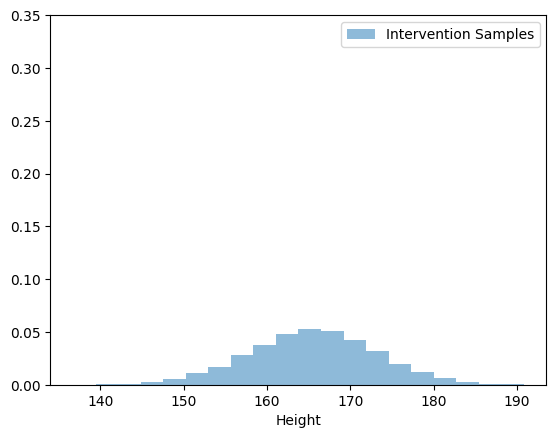

In [9]:
int_model = pyro.do(model, data={"femur": tensor(46.0)})    #A

int_samples = []    #B
for _ in range(10000):    #B
    _, _, int_height = int_model(exogenous)    #B
    int_samples.append(float(int_height))    #B

plt.hist(    #C
    int_samples,    #C
    bins=20,    #C
    alpha=0.5,    #C
    label="Intervention Samples",    #C
    density=True    #C
)
plt.ylim(0., .35)    #C
plt.legend()    #C
plt.xlabel("Height")    #C
plt.show()    #C

#A Implement the hypothetical condition "...if femur length were 46cm" with pyro.do, which returns a new model that implements the intervention.
#B Sample from the intervention distribution.
#C Visualize the intervention distribution with a histogram of samples.

We compare this to the counterfactual "An individual's femur is 44cm and their height is 165cm.  What would the height be if femur length was 46cm?"

![cf distribution](https://i.imgur.com/5KaSxnw.png)

In [ ]:
conditioned_model = pyro.condition(    #A
    model,    #A
    data={"femur": tensor(44.0), "height": tensor(165.0)}    #A
)    #A

def guide(exogenous):    #B
    p = param("p", tensor(.5), constraint=constraints.unit_interval)    #C
    n_sex = sample("N_sex", Bernoulli(p))    #C
    sex = sample("sex", Bernoulli(n_sex))    #D
    n_femur_loc = param("n_femur_loc", tensor(0.0))    #E
    n_femur_scale = param(    #E
        "n_femur_scale",    #E
        tensor(1.0),    #E
        constraint=constraints.positive    #E
    )    #E
    n_femur = sample("N_femur", Normal(n_femur_loc, n_femur_scale))    #F
    n_height_loc = param("n_height_loc", tensor(0.0))    #F
    n_height_scale = param(    #F
        "n_height_scale",    #F
        tensor(1.0),    #F
        constraint=constraints.positive    #F
    )    #F
    n_height = sample("N_height", Normal(n_height_loc, n_height_scale))    #F
    femur = sample("femur", Delta(n_femur))    #G
    height = sample("height", Delta(n_height))    #G

pyro.util.set_rng_seed(123)    #H
pyro.clear_param_store()    #I
svi = SVI(    #J
          model=conditioned_model,
          guide=guide,
          optim=Adam({"lr": 0.003}),    #K
          loss=Trace_ELBO()    #L
)

losses = []    #M
num_steps = 5000    #N
for t in range(num_steps):    #N
    losses.append(svi.step(exogenous))    #N

plt.plot(losses)    #O
plt.title("Loss During Training")    #O
plt.xlabel("step")    #O
plt.ylabel("loss")    #O

n_sex_p = param("p").item()    #P
n_femur_loc = param("n_femur_loc").item()    #P
n_femur_scale = param("n_femur_scale").item()    #P
n_height_loc = param("n_height_loc").item()    #P
n_height_scale = param("n_height_scale").item()    #P

exogenous_posterior = {    #Q
    'N_sex': Bernoulli(n_sex_p),    #Q
    'N_femur': Normal(n_femur_loc, n_femur_scale),    #Q
    'N_height': Normal(n_height_loc, n_height_scale),    #Q
}    #Q

#A Condition on actual world outcomes of a 58cm femur and 160cm height.
#B The exogenous prior distribution is passed to the guide function. The function won't use this argument, but the signatures of the guide and the model functions must match.
#C The guide function tries to approximate P(N_sex|femur, height) from a Bernoulli distribution.  Optimization targets the parameter of this Bernoulli distribution.
#D n_sex is either 0 or 1. When passed as a parameter to a Bernoulli, the outcome is deterministic.
#E The guide function tries to approximate P(N_femur|femur, height) from a Normal distribution.  Optimization targets the location and scale parameters of this Normal distribution.
#F The guide function tries to approximate P(N_height|femur, height) also from a Normal distribution.
#G Since we condition on femur and height, they are not needed in the guide function. But it is useful to have them in case we want to condition on different outcomes.
#H Set seed for reproducibility
#I Clear any current parameter values
#J Initialize the stochastic variational inference algorithm.
#K Optimize the parameters with a learning rate of .003.
#L Use evidence lower bound (ELBO) as the loss function.
#M Initialize a list to store loss values for plotting.
#N Run the optimization for 5000 steps.
#O Plot the loss during training.
#P Extract the parameter values.
#Q Do the abduction step by using the optimized parameters to create a new exogenous variable distributions.

/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'femur', 'height'}
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'femur', 'height'}
  warnings.warn(


Finally, I forward simulate from the counterfactual distribution by passing the exogenous distributions into the intervened-upon model.

![parallel world graph](https://i.imgur.com/5KaSxnw.png)

In [ ]:
cf_samples = []    #A
for _ in range(10000):    #A
    _, _, cf_height = int_model(exogenous_posterior)    #A
    cf_samples.append(float(cf_height))    #A

plt.hist(    #B
    int_samples,    #B
    bins=20,    #B
    alpha=0.5,    #B
    label="Intervention Samples",    #B
    density=True    #B
)
plt.hist(    #B
    cf_samples,    #B
    bins=20,    #B
    alpha=0.5,    #B
    label="Counterfactual Samples",    #B
    density=True    #B
)    #B
plt.ylim(0., .35)
plt.legend()    #B
plt.xlabel("Height")    #B
plt.show()    #B

#A Generate counterfactual samples by passing the posterior on noise variables to the intervention model.
#B Overlay both the interventional and counterfactual histograms.

# Normalizing flows example

In [ ]:
from torch import nn
import pandas as pd
from torch import tensor
import torch

df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/enzyme-data.csv")   #A

X = torch.tensor(df['x'].values).unsqueeze(1).float()    #B
Y = torch.tensor(df['y'].values).unsqueeze(1).float()    #B


from pyro.distributions import (
    ConditionalTransformedDistribution,
    Normal,
    Uniform,
    TransformedDistribution
)
from pyro.distributions.transforms import conditional_spline, spline
import torch
from torch.distributions.transforms import AffineTransform

pyro.set_rng_seed(348)

NxDist = Uniform(torch.zeros(1), torch.ones(1))     #A
f_x = AffineTransform(loc=1., scale=100.0)    #B
XDist = TransformedDistribution(NxDist, [f_x])    #C

NyDist = Normal(torch.zeros(1), torch.ones(1))    #D
f_y = conditional_spline(input_dim=1, context_dim=1)    #E
YDist = ConditionalTransformedDistribution(NyDist, [f_y])    #F

modules = torch.nn.ModuleList([f_y])    #H
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)    #H
losses = []
maxY = max(Y)    #I
Ynorm = Y / maxY    #I
for step in range(800):
    optimizer.zero_grad()    #J
    log_prob_x = XDist.log_prob(X)    #K
    log_prob_y = YDist.condition(X).log_prob(Ynorm)    #L
    loss = -(log_prob_x + log_prob_y).mean()    #M
    loss.backward()    #M
    optimizer.step()    #M
    XDist.clear_cache()
    YDist.clear_cache()
    losses.append(loss.item())

plt.plot(losses[1:])    #N
plt.title("Loss")    #N
plt.xlabel("step")    #N
plt.ylabel("loss")    #N

x_flow = XDist.sample(torch.Size([100,]))    #0
y_flow = YDist.condition(x_flow).sample(torch.Size([100,])) * maxY    #0

plt.title('Observed values of enzyme concentration X\n and protein concentration Y')    #P
plt.xlabel('X')    #P
plt.ylabel('Y')    #P
plt.xlim(0, 105)    #P
plt.ylim(0, 120)    #P
plt.scatter(X.squeeze(1), Y.squeeze(1), color='firebrick', label='Actual Data', alpha=0.5)  #P
plt.scatter(x_flow.squeeze(1), y_flow.squeeze(), label='Generated values from trained model', alpha=0.5)    #P
plt.legend()    #P
plt.show()    #P


In [ ]:
f_x.inv(torch.tensor([23.]))
f_y.condition(torch.tensor([23.])).inv(torch.tensor([77.]))